In [2]:
! nvidia-smi

Tue Jun 22 06:14:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
! pip install keras-tuner

     |████████████████████████████████| 102kB 6.4MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-cp37-none-any.whl size=9569 sha256=8a1533146abb9d4ebfcae42ace2537af1bb0cccfb42662e838abfb2d9d01ab67
  Stored in directory: /root/.cache/pip/wheels/95/99/a8/6b116b0f69be60cc475d1cd36680f3a09f284d86655bb99d93
Successfully built kt-legacy


In [4]:
import tensorflow
from tensorflow import keras
import keras_tuner as kt
import os
import numpy as np
# import keras
import keras.backend as K
from tensorflow.keras.layers import Input, Masking, LSTM, Dropout, Permute, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, concatenate, multiply, Reshape, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from matplotlib import pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
num_classes = 118

### Some utility functions

In [7]:
def load_X(path):
    X_signals = []
    files = os.listdir(path)
    files.sort(key=str.lower)
    #['train_acc_x.txt', 'train_acc_y.txt', 'train_acc_z.txt', 'train_gyr_x.txt', 'train_gyr_y.txt', 'train_gyr_z.txt']
    for my_file in files:
        fileName = os.path.join(path,my_file)
        file = open(fileName, 'r')
        X_signals.append(
            [np.array(cell, dtype=np.float32) for cell in [
                row.strip().split(' ') for row in file
            ]]
        )
        file.close()
        #X_signals = 6*totalStepNum*128
    X_signals = np.transpose(np.array(X_signals), (1, 0, 2))#(totalStepNum*6*128)
    return X_signals.reshape(-1,6,128,1)#(totalStepNum*6*128*1)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    y_ = y_ - 1
    #one_hot
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [8]:
def plot_performance(X_train, train_label):
    history = model.fit(X_train, train_label, validation_split = 0.1, epochs=100, shuffle=True, batch_size=512, callbacks=keras.callbacks.EarlyStopping(monitor='val_loss', patience=50))#, callbacks=[es_callback])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [9]:
def get_test_performance(model, X_test, test_label):
    score = model.evaluate(X_test, test_label, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

### Squeeze Excite Block

In [10]:
def squeeze_excite_block(tensor, ratio=16):
    init = tensor
    # channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[-1]
    se_shape = (1, filters)

    se = GlobalAveragePooling1D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    # if K.image_data_format() == 'channels_first':
    #     se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

# Dataset 1

# Model without Tuning

In [ ]:
def MLSTM_FCN(shape=shape, num_classes):
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = LSTM(units=8)(x)
    x = Dropout(0.8)(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")
    model.summary()

    return model


In [ ]:
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')

In [ ]:
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

In [ ]:
plot_performance(X_train, train_label)

In [ ]:
get_test_performance(model, X_test, test_label)

Test loss: 0.6743597388267517
Test accuracy: 0.9323529601097107


### Now it's Time for Tuner!

As we couldn't beat the dataset 1, so we tuned the hyperparameters.

# Model Tuned with keras Tuner

In [12]:
def MLSTM_FCN_tuned_all(hp):
    ip = Input(shape=(6, 128))
    x = Masking()(ip)
    x = LSTM(units=hp.Int('lstm_1', min_value=8, max_value=128, step=16))(x)
    x = Dropout(hp.Choice(name='Dropout', values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(hp.Int('conv_1_filter', min_value=8, max_value=128, step=16), hp.Choice(name='conv_1_filter_stride', values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Int('conv_2_filter', min_value=8, max_value=128, step=16), hp.Choice(name='conv_2_filter_stride',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Int('conv_3_filter', min_value=8, max_value=128, step=16), hp.Choice(name='conv_3_filter_stride',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 3*1e-1, 3*1e-2, 3*1e-3, 3*1e-4, 1e-4, 1.0])), \
                  loss='categorical_crossentropy',metrics=['accuracy'])
    # model.summary()

    return model

In [ ]:
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')

In [ ]:
tuner = kt.tuners.RandomSearch(
    MLSTM_FCN_tuned,
    objective='val_accuracy',
    max_trials=10,
    directory='output',
    project_name='MLSTM_FCN')

tuner.search(X_train, train_label, epochs=100, validation_split=0.1, callbacks=[tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)])

Trial 10 Complete [00h 19m 23s]
val_accuracy: 0.99516761302948

Best val_accuracy So Far: 0.9966777563095093
Total elapsed time: 02h 15m 32s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 128)]     0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 128, 6)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 128, 128)     6272        permute[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128)     512         conv1d[0][0]                     
______________________________________________________________________________________________

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_hyperparameters

In [ ]:
model.save('/content/drive/Shareddrives/MMH/models/MLSTM_FCN_tuned.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model = tensorflow.keras.models.load_model('/content/drive/Shareddrives/MMH/models/MLSTM_FCN_tuned.h5')

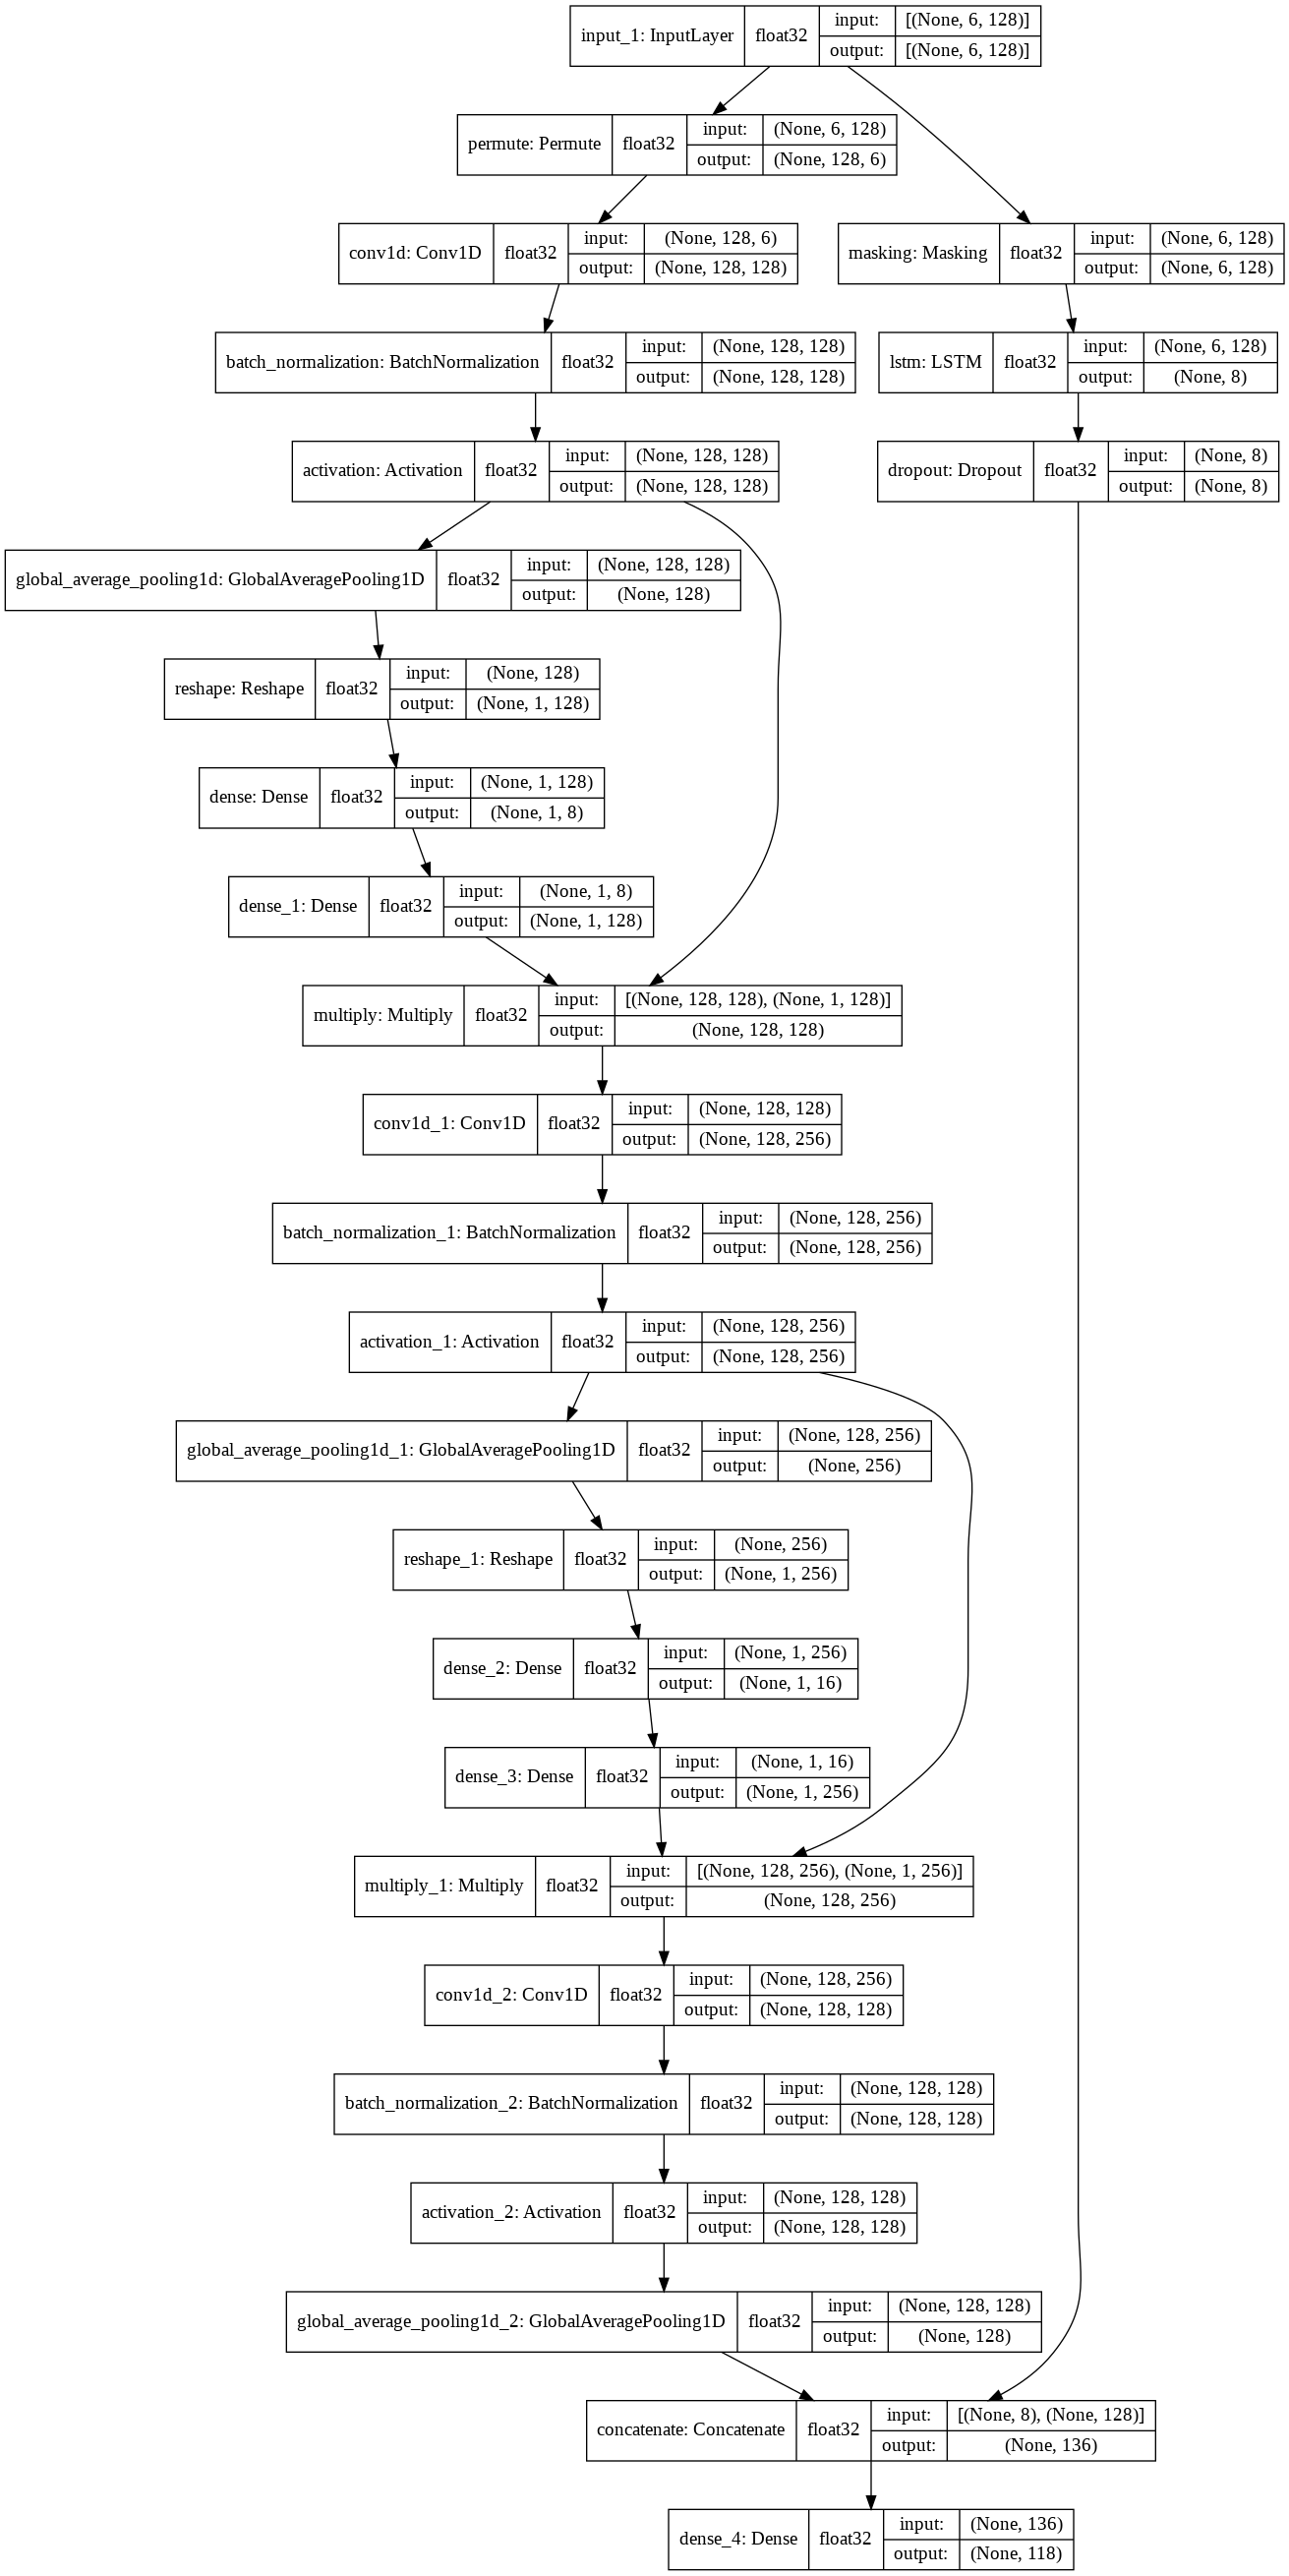

In [ ]:
tensorflow.keras.utils.plot_model(
    model, to_file='MLSTM_FCN_tuned.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

Epoch 1/100
59/59 [==============================] - 10s 96ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0306 - val_accuracy: 0.9949
Epoch 2/100
59/59 [==============================] - 4s 73ms/step - loss: 7.5259e-04 - accuracy: 0.9998 - val_loss: 0.0252 - val_accuracy: 0.9964
Epoch 3/100
59/59 [==============================] - 4s 73ms/step - loss: 5.8160e-04 - accuracy: 0.9998 - val_loss: 0.0240 - val_accuracy: 0.9967
Epoch 4/100
59/59 [==============================] - 4s 73ms/step - loss: 4.7363e-04 - accuracy: 0.9999 - val_loss: 0.0235 - val_accuracy: 0.9964
Epoch 5/100
59/59 [==============================] - 4s 74ms/step - loss: 3.9967e-04 - accuracy: 0.9999 - val_loss: 0.0233 - val_accuracy: 0.9964
Epoch 6/100
59/59 [==============================] - 4s 74ms/step - loss: 4.3300e-04 - accuracy: 0.9999 - val_loss: 0.0231 - val_accuracy: 0.9964
Epoch 7/100
59/59 [==============================] - 4s 74ms/step - loss: 3.2105e-04 - accuracy: 0.9999 - val_loss: 0.0230 - va

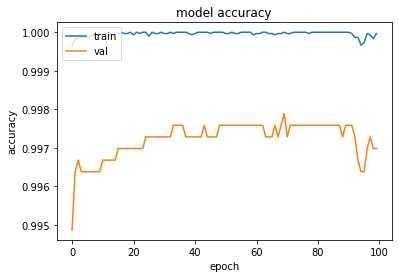

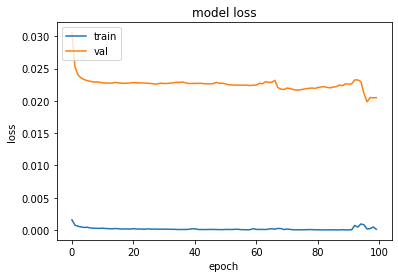

In [ ]:
history = model.fit(X_train, train_label, validation_split = 0.1, epochs=100, shuffle=True, batch_size=512, callbacks=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50))#, callbacks=[es_callback])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_test, test_label, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6833741068840027
Test accuracy: 0.9430481195449829


> Accuracy achived: 94.30 (Previous best: 93.52)

In [13]:
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')

In [14]:
tuner = kt.tuners.RandomSearch(
    MLSTM_FCN_tuned_all,
    objective='val_accuracy',
    max_trials=10,
    directory='output',
    project_name='MLSTM_FCN_1')

tuner.search(X_train, train_label, epochs=100, validation_split=0.1, callbacks=[tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)], shuffle=True)

Trial 10 Complete [00h 17m 02s]
val_accuracy: 0.9936575293540955

Best val_accuracy So Far: 0.9948655962944031
Total elapsed time: 02h 40m 35s
INFO:tensorflow:Oracle triggered exit


In [15]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 128)]     0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 128, 6)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 128, 72)      3528        permute[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 72)      288         conv1d[0][0]                     
______________________________________________________________________________________________

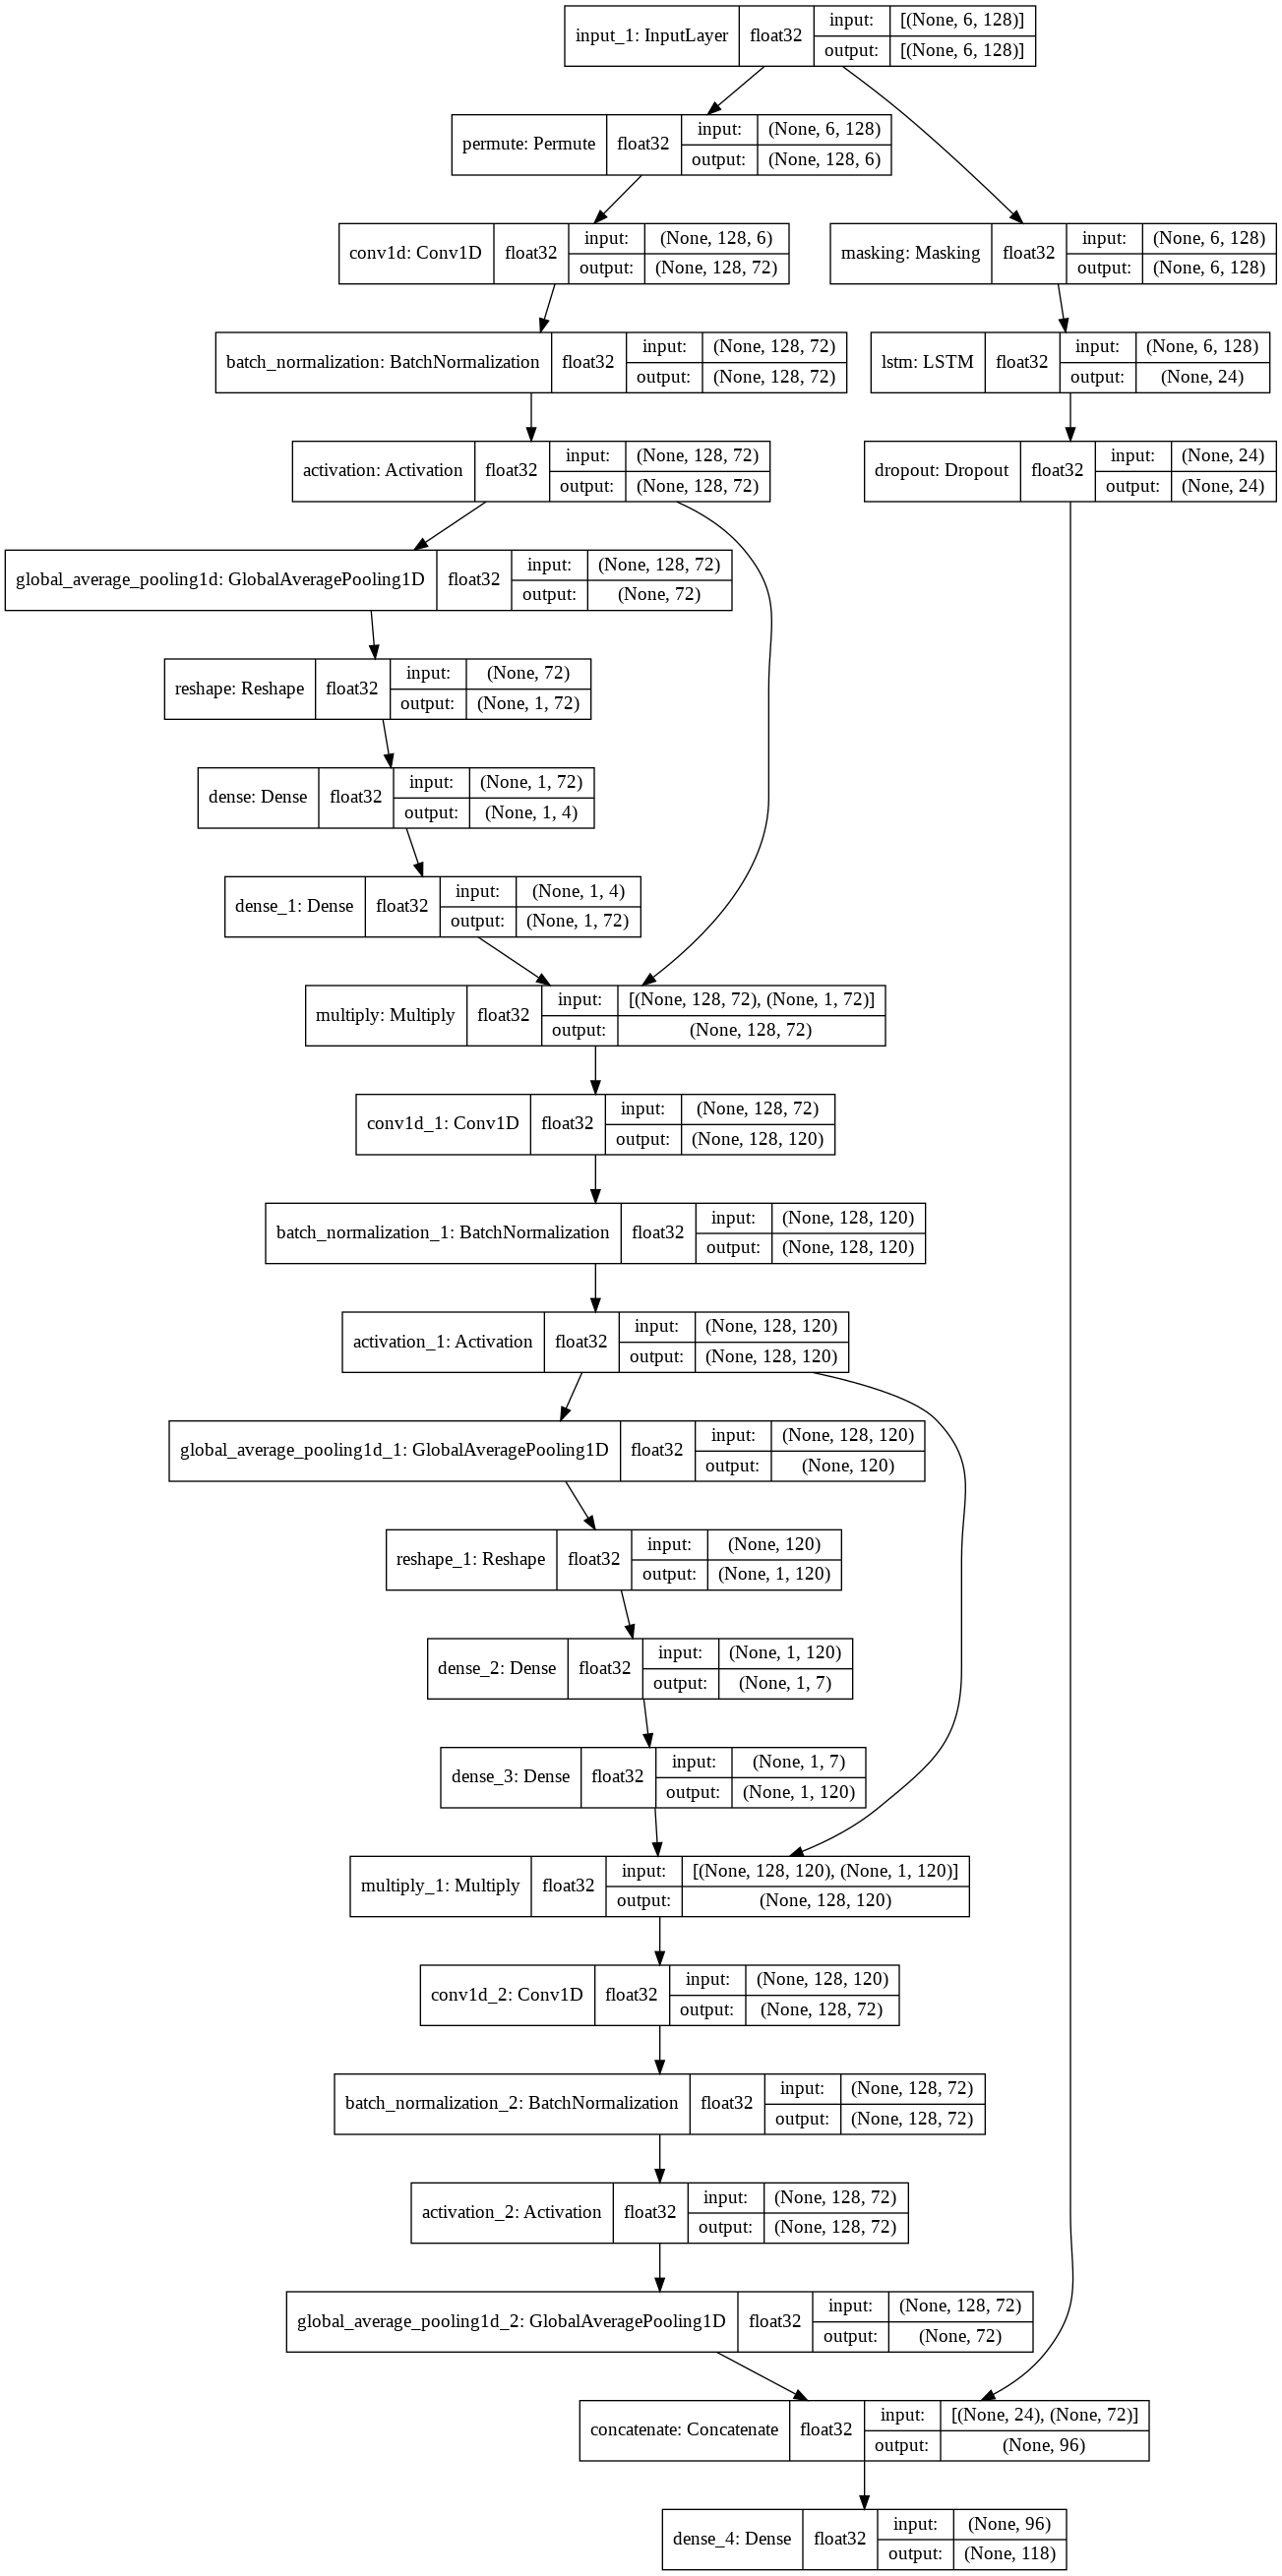

In [16]:
tensorflow.keras.utils.plot_model(
    model, to_file='/content/drive/Shareddrives/MMH/models/images/MLSTM_FCN_tuned_1.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

Epoch 1/100
59/59 [==============================] - 9s 75ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 0.0358 - val_accuracy: 0.9906
Epoch 2/100
59/59 [==============================] - 3s 47ms/step - loss: 8.1357e-04 - accuracy: 0.9999 - val_loss: 0.0259 - val_accuracy: 0.9943
Epoch 3/100
59/59 [==============================] - 3s 47ms/step - loss: 6.6263e-04 - accuracy: 0.9999 - val_loss: 0.0240 - val_accuracy: 0.9952
Epoch 4/100
59/59 [==============================] - 3s 47ms/step - loss: 6.7620e-04 - accuracy: 0.9999 - val_loss: 0.0236 - val_accuracy: 0.9955
Epoch 5/100
59/59 [==============================] - 3s 47ms/step - loss: 5.4685e-04 - accuracy: 0.9999 - val_loss: 0.0234 - val_accuracy: 0.9955
Epoch 6/100
59/59 [==============================] - 3s 47ms/step - loss: 5.2774e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 0.9955
Epoch 7/100
59/59 [==============================] - 3s 47ms/step - loss: 5.0468e-04 - accuracy: 0.9999 - val_loss: 0.0231 - val

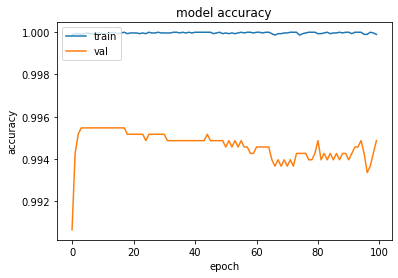

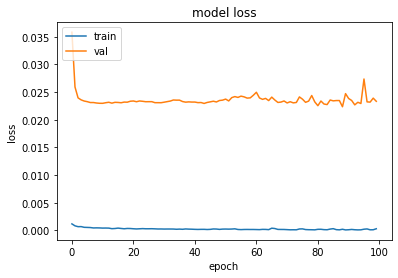

In [17]:
plot_performance(X_train, train_label)

In [18]:
get_test_performance(model, X_test, test_label)

Test loss: 0.6743305921554565
Test accuracy: 0.9430481195449829


In [19]:
model.save('/content/drive/Shareddrives/MMH/models/MLSTM_FCN_tuned_1.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [21]:
layers = ['lstm_1', 'Dropout', 'conv_1_filter', 'conv_1_filter_stride', 'conv_2_filter', 'conv_2_filter_stride', 'conv_3_filter', 'conv_3_filter_stride', 'learning_rate']

In [22]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print('Optimal Hyperparameters:')

for i in layers:
    print(f"{i}: {best_hyperparameters.get(i)}")

Optimal Hyperparameters:
lstm_1: 24
Dropout: 0.4
conv_1_filter: 72
conv_1_filter_stride: 8
conv_2_filter: 120
conv_2_filter_stride: 8
conv_3_filter: 72
conv_3_filter_stride: 9
learning_rate: 0.00030000000000000003


> Accuracy achived: 
 - Without Tuner: 93.23 (Previous best: 93.52)
 - With Tuner: 94.30